# **Modelling notebook**
In this jupiternotebook we conduct a machine learning analysis to be able to make predictions for the selling time for houses, based on different features. 

# Libraries and load

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import pickle
import json
from plotnine import *

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# import what we need for random forest
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

# import what we need for neural networks
import tensorflow
import keras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# remove futurewarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# make jupiter print all outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
# constants
USE_STORED_RF_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [3]:
# read in the cleaned csv
sellingtime_df = pd.read_csv('sellingtime.csv')

# show first rows 
sellingtime_df.head()

,link,house_size,plot_size,price,price_sqm,housetype,built_type,year_of_construction,energylabel,garden,...,area,duration_days,price_log,house properties,facilities,monetary specifications,english description,measureable properties,ambiance description,extra's
0,1,125,266,445000,3560,Eengezinswoning,Bestaande bouw,2013,Low,tuin,...,93,7,13.005830,0.017452,0.000000,0.000000,0.000000,0.003408,0.006838,0.027625
1,2,98,320,450000,4592,Eengezinswoning,Bestaande bouw,2006,Low,tuin,...,32,17,13.017003,0.007218,0.001430,0.000000,0.000000,0.000000,0.015851,0.076067
2,3,98,183,350000,3571,Eengezinswoning,Bestaande bouw,1990,Medium,tuin,...,13,18,12.765688,0.019417,0.000000,0.083266,0.000524,0.000000,0.022626,0.000000
3,4,177,405,400000,2260,Eengezinswoning,Bestaande bouw,1930,Medium,tuin,...,72,16,12.899220,0.013943,0.005059,0.001267,0.000000,0.020889,0.007830,0.052219
4,5,174,554,635000,3649,Eengezinswoning,Bestaande bouw,1999,Low,tuin,...,40,16,13.361380,0.005916,0.003539,0.000000,0.001411,0.000000,0.043602,0.052751


# Creating the train, test, and validation splits

In [4]:
# Making a class for splitting the dataset into train, test and validation
class TrainTestSplitter(object):

    # 80% of the dataset is train and 20% is validation set, Seed for always filling in a random number
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    # Get data into the sets that are made
    def split_train_test(self, sellingtime_df):
        print("Generating the train/validation/test splits...")
        self.train_set = sellingtime_df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = sellingtime_df.loc[lambda x: ~x.link.isin(self.train_set.link)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)

        print("split completed")

In [5]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()
fitting_splits.split_train_test(sellingtime_df)

Generating the train/validation/test splits...
split completed


In [6]:
# Check the sizes of the sets
fitting_splits.train_set.shape
fitting_splits.test_set.shape
fitting_splits.validation_set.shape

(34731, 22)

(8683, 22)

(6946, 22)

# Dummification and scaling

In [7]:
# fitting a one hot encoder transformer to the train
one_hot_encoder = OneHotEncoder() 
one_hot_encoder.fit(fitting_splits.train_set[['housetype', 'energylabel', 'built_type', 'garden']])

OneHotEncoder()

In [8]:
# looking at the train set
fitting_splits.train_set

,link,house_size,plot_size,price,price_sqm,housetype,built_type,year_of_construction,energylabel,garden,...,area,duration_days,price_log,house properties,facilities,monetary specifications,english description,measureable properties,ambiance description,extra's
23660,33520,115,124,435000,3783,Eengezinswoning,Bestaande bouw,1936,Medium,tuin,...,50,17,12.983101,0.023288,0.002480,0.000000,0.000014,0.000922,0.034044,0.005078
32553,46491,169,189,529500,3133,Eengezinswoning,Bestaande bouw,2001,Low,tuin,...,25,17,13.179688,0.028007,0.010454,0.022452,0.006172,0.001132,0.011334,0.024485
30728,43881,117,126,425000,3632,Eengezinswoning,Bestaande bouw,1987,Medium,tuin,...,30,16,12.959844,0.041359,0.000000,0.003497,0.000381,0.004510,0.019565,0.000000
39258,55957,76,2,150000,1974,Appartement,Bestaande bouw,1959,High,geen tuin,...,30,25,11.918391,0.000000,0.045718,0.070358,0.000000,0.005987,0.000619,0.000000
33275,47502,152,415,335000,2204,Landhuis,Bestaande bouw,1978,Medium,tuin,...,84,11,12.721886,0.017394,0.000000,0.000000,0.000000,0.047655,0.014057,0.030749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,6005,147,263,440000,2993,Eengezinswoning,Bestaande bouw,1976,Medium,geen tuin,...,56,11,12.994530,0.026857,0.000000,0.000000,0.000000,0.021917,0.032252,0.014667
21630,30620,116,129,310000,2672,Eengezinswoning,Bestaande bouw,1985,Medium,tuin,...,14,21,12.644328,0.029633,0.000000,0.000000,0.001786,0.000000,0.029314,0.000000
9812,13940,81,2,295000,3642,Appartement,Bestaande bouw,1962,Medium,tuin,...,14,19,12.594731,0.000000,0.040459,0.000000,0.002486,0.001207,0.014460,0.004696
34317,48937,147,161,345000,2347,Eengezinswoning,Bestaande bouw,2005,Low,tuin,...,68,13,12.751300,0.031506,0.003267,0.011901,0.000088,0.002873,0.014558,0.000000


In [9]:
# looking at what the encoder did, we dummify the categorical columns and show the results
one_hot_encoder.categories_ 
encoded_names = one_hot_encoder.get_feature_names()
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['housetype', 'energylabel', 'built_type', 'garden']]).toarray()
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['Appartement', 'Bungalow', 'Eengezinswoning', 'Landhuis', 'Overig'],
       dtype=object),
 array(['High', 'Low', 'Medium'], dtype=object),
 array(['Bestaande bouw', 'Nieuwbouw'], dtype=object),
 array(['balkon', 'geen tuin', 'tuin'], dtype=object)]

array(['x0_Appartement', 'x0_Bungalow', 'x0_Eengezinswoning',
       'x0_Landhuis', 'x0_Overig', 'x1_High', 'x1_Low', 'x1_Medium',
       'x2_Bestaande bouw', 'x2_Nieuwbouw', 'x3_balkon', 'x3_geen tuin',
       'x3_tuin'], dtype=object)

,x0_Appartement,x0_Bungalow,x0_Eengezinswoning,x0_Landhuis,x0_Overig,x1_High,x1_Low,x1_Medium,x2_Bestaande bouw,x2_Nieuwbouw,x3_balkon,x3_geen tuin,x3_tuin
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34726,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
34727,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
34728,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
34729,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
# after generating the dummy columns we replace the original data from the training set with the dummy columns which can be used in the machine learning proces
train_set = fitting_splits.train_set.drop(['housetype', 'energylabel', 'built_type', 'garden'], axis=1)
train_set.reset_index(drop=True, inplace=True)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,link,house_size,plot_size,price,price_sqm,year_of_construction,nr_rooms,nr_bedrooms,area,duration_days,...,x0_Landhuis,x0_Overig,x1_High,x1_Low,x1_Medium,x2_Bestaande bouw,x2_Nieuwbouw,x3_balkon,x3_geen tuin,x3_tuin
0,33520,115,124,435000,3783,1936,4,3,50,17,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,46491,169,189,529500,3133,2001,5,3,25,17,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,43881,117,126,425000,3632,1987,4,3,30,16,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,55957,76,2,150000,1974,1959,3,2,30,25,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,47502,152,415,335000,2204,1978,6,5,84,11,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34726,6005,147,263,440000,2993,1976,6,3,56,11,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
34727,30620,116,129,310000,2672,1985,5,4,14,21,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
34728,13940,81,2,295000,3642,1962,3,2,14,19,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
34729,48937,147,161,345000,2347,2005,5,4,68,13,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [11]:
# standardizing the features with the standardscaler
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)
standard_scaler.transform(train_set)

StandardScaler()

array([[ 0.14735713,  0.21528531, -0.2180942 , ..., -0.42445545,
        -0.48360208,  0.72126442],
       [ 0.87325187,  2.02374443,  0.26195499, ..., -0.42445545,
        -0.48360208,  0.72126442],
       [ 0.72718871,  0.28226528, -0.20332346, ..., -0.42445545,
        -0.48360208,  0.72126442],
       ...,
       [-0.9483964 , -0.92337413, -1.11910962, ..., -0.42445545,
        -0.48360208,  0.72126442],
       [ 1.01013712,  1.28696479,  0.05516457, ..., -0.42445545,
        -0.48360208,  0.72126442],
       [-0.83037065, -0.92337413, -1.11910962, ...,  2.35595988,
        -0.48360208, -1.38645409]])

In [12]:
# create a datapreparer class, this class will go through all the steps just performed when we call on it, this will be used to transform the other data sets
class DataPreparer(object):
    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = ['housetype', 'energylabel', 'built_type', 'garden']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names()
        df = df.drop(vars_to_encode, axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        df = self.dummify(df)
        df = self.scale(df)
        return df

In [13]:
# using the data preparer to transform train and validation
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
data_preparer.prepare_data(fitting_splits.train_set).head()
data_preparer.prepare_data(fitting_splits.validation_set).head()

,link,house_size,plot_size,price,price_sqm,year_of_construction,nr_rooms,nr_bedrooms,area,duration_days,...,x0_Landhuis,x0_Overig,x1_High,x1_Low,x1_Medium,x2_Bestaande bouw,x2_Nieuwbouw,x3_balkon,x3_geen tuin,x3_tuin
0,0.147357,0.215285,-0.218094,0.722761,0.610645,-1.179030,-0.370331,-0.142498,0.150477,-0.509764,...,-0.151075,-0.025176,-0.556431,-0.765671,1.240191,0.17949,-0.17949,-0.424455,-0.483602,0.721264
1,0.873252,2.023744,0.261955,1.487980,-0.120849,0.851025,0.406029,-0.142498,-0.879075,-0.509764,...,-0.151075,-0.025176,-0.556431,1.306043,-0.806327,0.17949,-0.17949,-0.424455,-0.483602,0.721264
2,0.727189,0.282265,-0.203323,0.641785,0.440713,0.413782,-0.370331,-0.142498,-0.673165,-0.609102,...,-0.151075,-0.025176,-0.556431,-0.765671,1.240191,0.17949,-0.17949,-0.424455,-0.483602,0.721264
3,1.402997,-1.090824,-1.119110,-1.585043,-1.425159,-0.460703,-1.146690,-1.071382,-0.673165,0.284940,...,-0.151075,-0.025176,1.797168,-0.765671,-0.806327,0.17949,-0.17949,-0.424455,2.067816,-1.386454
4,0.929830,1.454415,1.931049,-0.086995,-1.166322,0.132698,1.182389,1.715270,1.550667,-1.105792,...,6.619229,-0.025176,-0.556431,-0.765671,1.240191,0.17949,-0.17949,-0.424455,-0.483602,0.721264


,link,house_size,plot_size,price,price_sqm,year_of_construction,nr_rooms,nr_bedrooms,area,duration_days,...,x0_Landhuis,x0_Overig,x1_High,x1_Low,x1_Medium,x2_Bestaande bouw,x2_Nieuwbouw,x3_balkon,x3_geen tuin,x3_tuin
0,-1.408467,-1.559684,-1.119110,-0.459482,1.598724,-1.647504,-1.146690,-1.071382,0.768208,0.284940,...,-0.151075,-0.025176,-0.556431,-0.765671,1.240191,0.17949,-0.17949,-0.424455,-0.483602,0.721264
1,-0.800430,-0.086125,3.112709,1.208614,1.608852,-1.241493,0.406029,0.786386,0.891754,0.781630,...,-0.151075,-0.025176,1.797168,-0.765671,-0.806327,0.17949,-0.17949,-0.424455,-0.483602,0.721264
2,-1.195249,-0.287064,-1.119110,-0.370409,-0.270524,-1.460115,-0.370331,-1.071382,-1.002621,-0.807778,...,-0.151075,-0.025176,1.797168,-0.765671,-0.806327,0.17949,-0.17949,2.355960,-0.483602,-1.386454
3,-0.150869,0.516695,-0.188553,-0.491873,-1.060537,0.195161,0.406029,0.786386,-0.178980,-0.708440,...,-0.151075,-0.025176,-0.556431,1.306043,-0.806327,0.17949,-0.17949,-0.424455,-0.483602,0.721264
4,-0.018181,-0.588474,0.261955,0.317883,1.114813,0.257624,-0.370331,-0.142498,-1.414442,-1.403806,...,-0.151075,-0.025176,-0.556431,-0.765671,1.240191,0.17949,-0.17949,-0.424455,-0.483602,0.721264


# Modeling with Random Forest

In [14]:
# get the transformed train set 
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['duration_days', 'link'], axis=1) 
y_train = fitting_splits.train_set['duration_days']


RandomForestRegressor(random_state=0)

In [ ]:
# create the model with the randomforestregressor, starting with 100 trees
funda_rf = RandomForestRegressor(n_estimators=100,random_state=0)
# fit the model instance on X_train
funda_rf.fit(X=X_train, y=y_train)

In [15]:
# now we use the fitted model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['duration_days', 'link'], axis=1)
y_test = fitting_splits.test_set['duration_days']

funda_rf.score(X_test,y_test)

0.11708581416055608

In [16]:
# calculate model score
print("Random Forest Regression Model Score is ",round(funda_rf.score(X_test,y_test)*100))

Random Forest Regression Model Score is  12


In [17]:
# create a definition for printing results
def results(y_value, X_value, model_to_try):
    pred =model_to_try.predict(X_value)
    p=(
        print('MAE:', round(metrics.mean_absolute_error(y_value, pred),2)),
        print('MSE:', round(metrics.mean_squared_error(y_value, pred),2)),  
        print('R-squared scores:', round(metrics.r2_score(y_value, pred),2))
    )

# print results for test data set for our basic random forest model
results(y_test, X_test, funda_rf)

MAE: 6.94
MSE: 88.28
R-squared scores: 0.12


## Hypertuning random forest

In [18]:
# preparing the data for hypertuning
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['duration_days','link'], axis=1)
y_validation = fitting_splits.validation_set['duration_days']

# combining train and validation in a seperate dataframe for testing our models later on
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['duration_days']])

In [19]:
# listing some parameters with possible values to test during hypertuning
parameters = {
    'bootstrap': [True],
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [80, 90, 100, 110]
}

In [20]:
# as hypertuning takes a long time we check if the hypertuning has already been performed, if it has been performed we take the file we made that contains the information instead of running it again.
if  os.path.exists('../downloads/gridforest_st.pickle') and USE_STORED_RF_HYPERTUNED_MODELS is True:
    with open('../downloads/gridforest_st.pickle', 'rb') as handle:
        gridforest_st = pickle.load(handle)
else:
    gridforest_st = GridSearchCV(funda_rf, param_grid=parameters, cv=3, n_jobs = -1)
    gridforest_st.fit(X=X_train_validation, y=y_train_validation)

    # save the results of the hypertuning so we do not have to keep repeating it
    with open('../downloads/gridforest_st.pickle', 'wb') as handle:
        pickle.dump(gridforest_st, handle)

In [21]:
# best params shows what parameters were used for the best results in hypertuning, best estimator are the estimations based on those parameters
gridforest_st.best_params_
best_grid = gridforest_st.best_estimator_

{'bootstrap': True, 'max_depth': 80, 'n_estimators': 150}

In [22]:
# printing results for test set based on the results of the hypertuning, results are far
results(y_test, X_test, best_grid)

MAE: 6.95
MSE: 88.11
R-squared scores: 0.12


In [23]:
# making a new random forest regressor with the results of our hypertuning as input
best_rf = RandomForestRegressor(n_estimators=150,random_state=0,max_depth=80, bootstrap=True)
best_rf.fit(X=X_train_validation, y=y_train_validation)

RandomForestRegressor(max_depth=80, n_estimators=150, random_state=0)

In [24]:
# printing results for test set with the new random forest model
results(y_test, X_test, best_rf)

MAE: 6.94
MSE: 88.1
R-squared scores: 0.12


# Modeling with Neural Network

In [ ]:
# checking the number of neurons to use for the input layer, as a start the number of columns +1 divided by 2 will be used
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

In [25]:
# creating a neural network model
nn_sellingtime = Sequential()
nn_sellingtime.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
nn_sellingtime.add(Dense(1))

# checking the structure of the neural network we created
print(nn_sellingtime.summary())

The number of neurons for the input layer must be: 29


In [27]:
# compiling the data to tensorflow which gives us the ability to train the model, also adding the loss function and optimizer to the neural network
nn_sellingtime.compile(loss='mean_absolute_error', optimizer='adam')

In [28]:
# checking the shape
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

(34731, 29)

(34731,)

(6946, 29)

(6946,)

In [29]:
# fitting a neural network on train data with validation data added to check if it is overfitting
nn_sellingtime.fit(X_train, y_train, epochs=100, batch_size = 20, validation_data=(X_validation, y_validation))

Epoch 1/100
1737/1737 [==============================] - 2s 899us/step - loss: 10.3768 - val_loss: 7.3779
Epoch 2/100
1737/1737 [==============================] - 1s 586us/step - loss: 7.2713 - val_loss: 7.1886
Epoch 3/100
1737/1737 [==============================] - 1s 606us/step - loss: 7.1547 - val_loss: 7.1173
Epoch 4/100
1737/1737 [==============================] - 1s 539us/step - loss: 7.1005 - val_loss: 7.1056
Epoch 5/100
1737/1737 [==============================] - 1s 543us/step - loss: 7.0666 - val_loss: 7.0652
Epoch 6/100
1737/1737 [==============================] - 1s 540us/step - loss: 7.0398 - val_loss: 7.0411
Epoch 7/100
1737/1737 [==============================] - 1s 543us/step - loss: 7.0202 - val_loss: 7.0313
Epoch 8/100
1737/1737 [==============================] - 1s 539us/step - loss: 7.0116 - val_loss: 7.0336
Epoch 9/100
1737/1737 [==============================] - 1s 543us/step - loss: 6.9991 - val_loss: 7.0172
Epoch 10/100
1737/1737 [==============================

dict_keys(['loss', 'val_loss'])

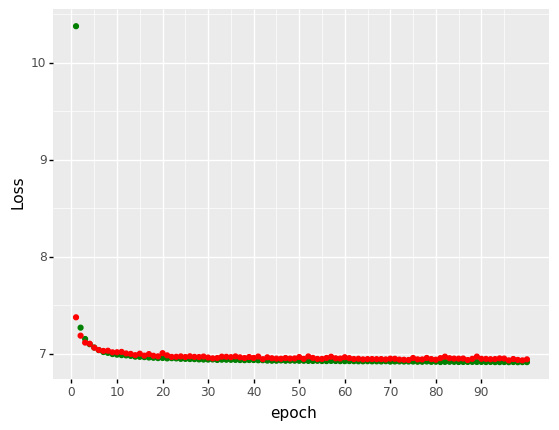

<ggplot: (83637689549)>

In [30]:
# see what information has been logged during the training process, then use these values to create a definition that can create plots
nn_sellingtime.history.history.keys()

def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch = np.arange(1, 101))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks = np.arange(0, 100, 10)) +
        ylab("Loss")
    )
    return p
plot_loss(nn_sellingtime)

In [33]:
# creating a new neutal network and fitting it with train_validation
nn_sellingtime_f = Sequential()
nn_sellingtime_f.add(Dense(15, input_dim=X_train.shape[1], activation='relu'))
nn_sellingtime_f.add(Dense(1))
nn_sellingtime_f.compile(loss='mean_absolute_error', optimizer='adam')
nn_sellingtime_f.fit(X_train_validation, y_train_validation, epochs=100, batch_size = 20)

# printing the prediction for test with the new model
results(y_test, X_test, nn_sellingtime_f)

Epoch 1/100
2084/2084 [==============================] - 2s 673us/step - loss: 10.6530
Epoch 2/100
2084/2084 [==============================] - 1s 574us/step - loss: 7.2313
Epoch 3/100
2084/2084 [==============================] - 1s 546us/step - loss: 7.1173
Epoch 4/100
2084/2084 [==============================] - 1s 566us/step - loss: 7.0666
Epoch 5/100
2084/2084 [==============================] - 1s 554us/step - loss: 7.0351
Epoch 6/100
2084/2084 [==============================] - 1s 583us/step - loss: 7.0170
Epoch 7/100
2084/2084 [==============================] - 2s 864us/step - loss: 7.0071
Epoch 8/100
2084/2084 [==============================] - 1s 568us/step - loss: 6.9977
Epoch 9/100
2084/2084 [==============================] - 1s 562us/step - loss: 6.9936
Epoch 10/100
2084/2084 [==============================] - 1s 547us/step - loss: 6.9851
Epoch 11/100
2084/2084 [==============================] - 1s 551us/step - loss: 6.9855
Epoch 12/100
2084/2084 [===========================

MAE: 6.97
MSE: 95.34
R-squared scores: 0.05


## Hypertuning neutral network

In [34]:
# make a function that creates a neural network, this will be used in the hypertuning
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))
    nn_model.add(Dense(1))
    nn_model.compile(loss='mean_absolute_error', optimizer='adam')
    return nn_model

seed = 1234
np.random.seed(seed)

# convert the keras model to a sklearn model, this is required before we can do hypertuning
model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [35]:
# listing some of the model parameters with possible values to test during hypertuning
batch_size = [10, 20]
epochs = [50, 80, 110]
neurons = [15, 25]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [37]:
# as hypertuning takes a long time we check if the hypertuning has already been performed, if it has been performed we take the file we made that contains the information instead of running it again.
if os.path.exists("../downloads/gridnn_st.pickle") and USE_STORED_NN_HYPERTUNED_MODELS is True:
    with open('../downloads/gridnn_st.pickle', 'rb') as handle:
        gridnn_st = pickle.load(handle)
else:
    gridnn_st = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, cv=3)
    gridnn_st = gridnn_st.fit(X_train_validation, y_train_validation)
    
    # save the results of the hypertuning so we do not have to keep repeating it
with open('../downloads/gridnn_st.pickle', 'wb') as handle:
    pickle.dump(gridnn_st, handle)

INFO:tensorflow:Assets written to: C:\Users\royup\AppData\Local\Temp\tmpgxq3uq60\assets


In [38]:
# printing the best parameters found in the hypertuning
print("The best parameter combination is: {}".format(gridnn_st.best_params_))

The best parameter combination is: {'batch_size': 10, 'epochs': 50, 'neurons': 15}


In [39]:
# creating a new model based on the outputs from the hypertuning
best_model_st = create_model(15)
best_model_st.fit(X_train_validation, y_train_validation, epochs=50, batch_size=10)

Epoch 1/50
4168/4168 [==============================] - 3s 693us/step - loss: 9.1199
Epoch 2/50
4168/4168 [==============================] - 3s 789us/step - loss: 7.1708
Epoch 3/50
4168/4168 [==============================] - 3s 637us/step - loss: 7.0775
Epoch 4/50
4168/4168 [==============================] - 3s 633us/step - loss: 7.0367
Epoch 5/50
4168/4168 [==============================] - 3s 628us/step - loss: 7.0199
Epoch 6/50
4168/4168 [==============================] - 3s 644us/step - loss: 7.0048
Epoch 7/50
4168/4168 [==============================] - 4s 927us/step - loss: 6.9978
Epoch 8/50
4168/4168 [==============================] - 4s 1ms/step - loss: 6.9943
Epoch 9/50
4168/4168 [==============================] - 3s 655us/step - loss: 6.9903
Epoch 10/50
4168/4168 [==============================] - 3s 642us/step - loss: 6.9849
Epoch 11/50
4168/4168 [==============================] - 3s 665us/step - loss: 6.9824
Epoch 12/50
4168/4168 [==============================] - 3s 650us

In [40]:
# printing the neural network results after hypertuning
results(y_test, X_test, best_model_st)

MAE: 6.95
MSE: 95.03
R-squared scores: 0.05


# Comparing the models

Both models are not very good for explaining the randomness with an R-squared of 0.12 for the random forest and 0.05 for the neural network.
Both models saw little to no change in their ability to predict the test data after hypertuning, this matches our observations from the EDA where sellingtime did not look correlated with any other metrics.